<a href="https://colab.research.google.com/github/ShaunakSen/Deep-Learning/blob/master/NN_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The spelled-out intro to neural networks and backpropagation: building micrograd

> Notes on tutorial by Andrej Karpathy: https://www.youtube.com/watch?v=VMj-3S1tku0

> Micrograd: https://github.com/karpathy/micrograd

---



In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

In [9]:
xs = np.linspace(-10, 10, num=100)
ys = f(xs)

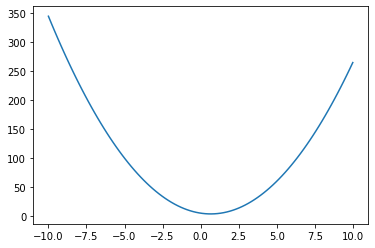

In [10]:
plt.plot(xs, ys);

We know that by defn the derivative tells us that if we have a value of x

and if we inc x slightly - then how does the f(x) respond - how __sensitive__ is f(x) to a slight change in x 

### Analytically finding derivative

In [12]:
h = 0.001
x = 3
# lets see how much f(x) changes by inc x -> x+h
print(f(x), f(x+h))

slope = (f(x+h) - f(x))/h
 
print (slope)

20 20.014003000000002
14.00300000000243


So when h->0, at 3, the slope is 14

`d(f(x))/dx at x=3 = 6(3)-4 = 14`

When x=-3:

In [13]:
h = 0.001
x = -3
# lets see how much f(x) changes by inc x -> x+h
print(f(x), f(x+h))

slope = (f(x+h) - f(x))/h
 
print (slope)

44 43.978003
-21.996999999998934


So when h->0, at -3, the slope is -22

`d(f(x))/dx at x=-3 = 6(-3)-4 = -22`


At some pt the derivative will be 0

- what this means is that at that pt, even if we nudge x by a slight amount, f(x) wont change
- this value is -2/3 for f(x)

### More complex expressions

In [15]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print (d)

4.0


We want to find derivative of d wrt a,b and c

In [16]:
h = 0.0001

d_base = a*b + c
d_final = (a+h)*b + c
print ('derivative of d wrt a:', (d_final-d_base)/h)


derivative of d wrt a: -3.000000000010772


In [17]:
d_final = a*(b+h) + c
print ('derivative of d wrt b:', (d_final-d_base)/h)

derivative of d wrt b: 2.0000000000042206


In [18]:
d_final = a*b + (c+h)
print ('derivative of d wrt c:', (d_final-d_base)/h)

derivative of d wrt c: 0.9999999999976694


### Creating a Value object

`_children` - basically tells us which values resulted in the new value - so for d=a*b, we store info of both a and b

`_op` - basically stores the operation as a simple string

In [46]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        if len(self.label) > 0:
            return f"{self.label} = Value(data={self.data})"
        else:
            return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c= Value(10.0, label='c')
print (a._prev, b._prev) # should be empty
d = a.__mul__(b) # children should be (a, b)
print (d._prev) # {a, b}
print (d._op) # should be * as d was formed by * operation on d._prev

set() set()
{b = Value(data=-3.0), a = Value(data=2.0)}
*


In [47]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c= Value(10.0, label='c')
print (a._prev, b._prev) # should be empty
d = (a.__mul__(b)).__add__(c); d.label='d' 
print (d)

print (d._prev) # Value(a*b), Value(c)
print (d._op)

set() set()
d = Value(data=4.0)
{c = Value(data=10.0), Value(data=-6.0)}
+


### Util functions to visulaize these expressions

In [50]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

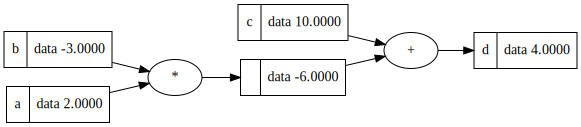

In [51]:
draw_dot(d)